# ASSIGNMENT - 1 - SAI KIRAN PULLABHATLA - A8MOH5

# Step 1: Load Data

In [1]:
import pandas as pd


data = pd.read_csv("C://Users//saiki//Desktop//ELTE University//3D Sensing and Sensor Fusion//Assignments//Assignment - 1//OneDrive_1_11-6-2024//fordulokor.csv", delimiter=';')

# Step 2: Filter data based on velocity

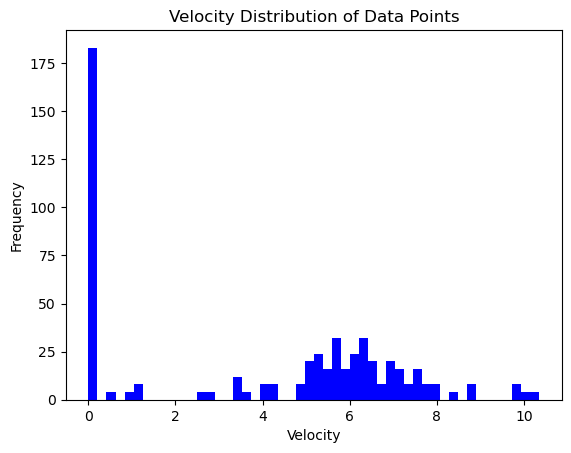

In [94]:
# Plot the distribution of velocity to check for any patterns
plt.figure()
plt.hist(data['Vel'], bins=50, color='blue')
plt.xlabel('Velocity')
plt.ylabel('Frequency')
plt.title('Velocity Distribution of Data Points')
plt.show()

velocity_min = 5  # Minimum velocity threshold
velocity_max = 7  # Maximum velocity threshold
filtered_data = data[(data['Vel'] >= velocity_min) & (data['Vel'] <= velocity_max)]

# Step 3: Convert GPS coordinates to Cartesian (x, y, z) coordinates

In [119]:
import numpy as np


R = 6371000  # Earth's radius in meters

lat_rad = np.radians(filtered_data['Lat'])
lon_rad = np.radians(filtered_data['Lon'])


x = R * np.cos(lat_rad) * np.cos(lon_rad)
y = R * np.cos(lat_rad) * np.sin(lon_rad)
z = R * np.sin(lat_rad)

# Step 4: Project 3D points to 2D plane

In [120]:
# Reference point is the mean of all points in 3D space
ref_point = np.array([x.mean(), y.mean(), z.mean()])
normal_vector = ref_point / np.linalg.norm(ref_point)

# Define the x-axis of the 2D plane as an arbitrary vector perpendicular to the normal vector
arbitrary_vector = np.array([1, 0, 0])
x_axis_2d = arbitrary_vector - np.dot(arbitrary_vector, normal_vector) * normal_vector
x_axis_2d /= np.linalg.norm(x_axis_2d)

# Define the y-axis of the 2D plane as perpendicular to both the normal vector and x-axis
y_axis_2d = np.cross(normal_vector, x_axis_2d)

# Step 4: Project each 3D point to the 2D plane
def project_point_to_plane(point, ref_point, x_axis_2d, y_axis_2d):
    vec = point - ref_point
    x_2d = np.dot(vec, x_axis_2d)
    y_2d = np.dot(vec, y_axis_2d)
    return x_2d, y_2d

# Project points to 2D
x_2d = []
y_2d = []
for i in range(len(x)):
    px, py = project_point_to_plane(np.array([x.iloc[i], y.iloc[i], z.iloc[i]]), ref_point, x_axis_2d, y_axis_2d)
    x_2d.append(px)
    y_2d.append(py)

x_2d = np.array(x_2d)
y_2d = np.array(y_2d)


# Step 5: RANSAC Circle Fitting

In [132]:
# RANSAC parameters
max_iterations = 1000
threshold_error = 0.15  # Adjusted threshold for better accuracy
threshold_inliers = 50  # Increased to require more inliers for a valid circle

# Function to compute a circle passing through three points
def circle_from_three_points(p1, p2, p3):
    A = np.array([[p1[0] - p2[0], p1[1] - p2[1]], [p2[0] - p3[0], p2[1] - p3[1]]])
    B = np.array([(p1[0]**2 - p2[0]**2 + p1[1]**2 - p2[1]**2) / 2, 
                  (p2[0]**2 - p3[0]**2 + p2[1]**2 - p3[1]**2) / 2])
    try:
        center = np.linalg.solve(A, B)
    except np.linalg.LinAlgError:
        raise ValueError("Points are collinear and do not define a unique circle")
    radius = np.sqrt((p1[0] - center[0])**2 + (p1[1] - center[1])**2)
    return center[0], center[1], radius

# Function to calculate the mean absolute error for a circle model
def calculate_error(x, y, center_x, center_y, radius):
    distances = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    return np.mean(np.abs(distances - radius))

# RANSAC for circle fitting
def ransac_circle(x, y, max_iterations, threshold_error, threshold_inliers):
    best_model = None
    best_error = float('inf')
    max_inliers = 0

    for k in range(max_iterations):
        # Select 3 random points to form the initial candidate circle
        sample_indices = random.sample(range(len(x)), 3)
        p1, p2, p3 = (x[sample_indices[0]], y[sample_indices[0]]), (x[sample_indices[1]], y[sample_indices[1]]), (x[sample_indices[2]], y[sample_indices[2]])
        
        # Calculate the initial candidate circle
        try:
            center_x, center_y, radius = circle_from_three_points(p1, p2, p3)
        except ValueError:
            continue  
        
        # Determine inliers for the initial candidate circle
        distances = np.sqrt((x - center_x)**2 + (y - center_y)**2)
        inliers = np.abs(distances - radius) <= threshold_error
        num_inliers = np.sum(inliers)


        # Calculate the error for the current model
        current_error = calculate_error(x[inliers], y[inliers], center_x, center_y, radius)
        
        # Update best model if the current model has more inliers and lower error
        if num_inliers > max_inliers or (num_inliers == max_inliers and current_error < best_error):
            best_model = (center_x, center_y, radius)
            best_error = current_error
            max_inliers = num_inliers

    return best_model

# Run RANSAC to fit a circle on the projected 2D data
best_circle = ransac_circle(x_2d, y_2d, max_iterations, threshold_error, threshold_inliers)


# Step 6: Print the Center and Radius of the best circle

In [135]:
theta = np.linspace(0, 2 * np.pi, 100)
circle_x = center_x + radius * np.cos(theta)
circle_y = center_y + radius * np.sin(theta)
center_x, center_y, radius = best_circle
print(f"Best Circle Center: ({center_x:.2f}, {center_y:.2f})")
print(f"Best Circle Radius: {radius:.2f}")

Best Circle Center: (1.13, 0.80)
Best Circle Radius: 4.18


# Step 6: Plot all data points to visualize circular paths

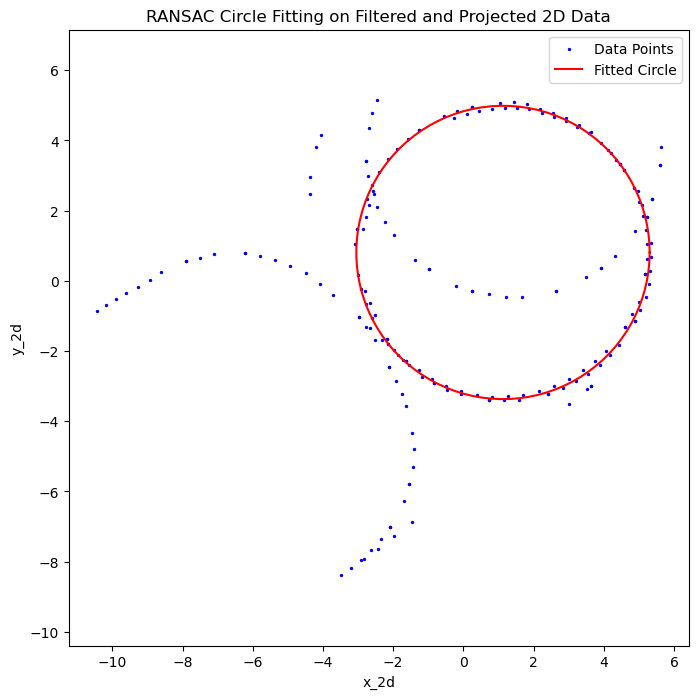

In [136]:
# Plot the data points and fitted circle
plt.figure(figsize=(8, 8))
plt.scatter(x_2d, y_2d, s=2, color='blue', label='Data Points')
plt.plot(circle_x, circle_y, color='red', label='Fitted Circle')
plt.xlabel('x_2d')
plt.ylabel('y_2d')
plt.title('RANSAC Circle Fitting on Filtered and Projected 2D Data')
plt.axis('equal')
plt.legend()
plt.show()

# Step 7: Plot the RANSAC inliers

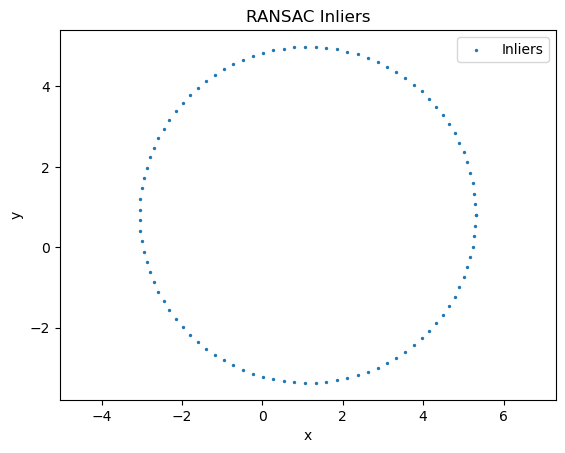

In [137]:
plt.scatter(circle_x, circle_y, s=2, label='Inliers')
plt.xlabel('x')
plt.ylabel('y')
plt.title('RANSAC Inliers')
plt.axis('equal')
plt.legend()
plt.show()

# Step 8: Save the file in XYZ for Mesh lab

In [147]:
import os
# Assuming best_circle contains the fitted circle parameters (center_x, center_y, radius)
center_x, center_y, radius = best_circle

# Calculate distances of all points to the fitted circle
distances = np.sqrt((x_2d - center_x)**2 + (y_2d - center_y)**2)

# Select inliers based on the threshold_error
inliers = np.abs(distances - radius) <= threshold_error

# Create a DataFrame for inliers with 'x', 'y', and 'z' columns
inliers_data = pd.DataFrame({
    'x': x_2d[inliers],
    'y': y_2d[inliers],
    'z': np.zeros(np.sum(inliers))  # Set z to 0 for 2D points
})
# Define the file path
xyz_file_path = os.path.abspath('circle_inliers.xyz')

inliers_data[['x', 'y', 'z']].to_csv('circle_inliers.xyz', sep=' ', index=False, header=False)
# Save the inliers to an XYZ file for MeshLab
print(f"XYZ file of fitted circle inliers saved at {xyz_file_path}")

XYZ file of fitted circle inliers saved at C:\Users\saiki\3D Sensing and Sensor Fusion\circle_inliers.xyz
